In [1]:
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/date_osint'


Mounted at /content/drive


In [60]:
import os
print(os.listdir(data_path))

['tiktok.com-2025-11-06T130922.ndjson', 'tiktok.com-2025-11-06T131138.ndjson', 'twitter.com-2025-11-06T133318.ndjson', 'twitter.com-2025-11-06T134242.ndjson', 'twitter.com-2025-11-06T134333.ndjson', 'twitter.com-2025-11-06T135100.ndjson', 'twitter.com-2025-11-06T135259.ndjson']


In [87]:
from datetime import datetime
import json
import pandas as pd
import glob


UNIFIED_COLUMNS = [
    'post_id', 'platform', 'user_id', 'follower_count',
    'post_timestamp_utc', 'post_date', 'post_time_of_day',
    'text_content', 'hashtags', 'language', 'total_engagement',
    'retweet_count', 'like_count', 'reply_count', 'is_retweet'
]

def extract_twitter_data(record):

    is_retweet = 'retweeted_status_result' in record['data']

    if is_retweet:
        tweet_data = record['data']['retweeted_status_result']['result']['legacy']
        user_data = record['data']['retweeted_status_result']['result']['core']['user_results']['result']['legacy']

    else:
        tweet_data = record['data']['legacy']
        user_data = record['data']['core']['user_results']['result']['legacy']

    # Se extrag campurile de baza
    post_id = tweet_data.get('id_str')

    text_content = tweet_data.get('full_text', tweet_data.get('text', ''))

    retweet_count = tweet_data.get('retweet_count', 0)
    like_count = tweet_data.get('favorite_count', 0)
    reply_count = tweet_data.get('reply_count', 0)

    timestamp_str = tweet_data.get('created_at')
    language = tweet_data.get('lang', 'unknown')

    user_id = user_data.get('screen_name')
    follower_count = user_data.get('followers_count', 0)

    # Se extrag hashtagurile
    hashtags = [
        h['text'].lower()
        for h in tweet_data.get('entities', {}).get('hashtags', [])
    ]

    post_timestamp_utc = None
    post_date = None
    post_time_of_day = None

    try:
        dt_object = datetime.strptime(timestamp_str, '%a %b %d %H:%M:%S +0000 %Y')
        post_timestamp_utc = dt_object.isoformat()
        post_date = dt_object.date().isoformat()
        post_time_of_day = dt_object.hour
    except Exception as e:
        print(f"Eroare la citirea timpului ({timestamp_str}): {e}")

    total_engagement = retweet_count + like_count + reply_count

    return {
        'post_id': post_id,
        'platform': 'Twitter',
        'user_id': user_id,
        'follower_count': follower_count,
        'post_timestamp_utc': post_timestamp_utc,
        'post_date': post_date,
        'post_time_of_day': post_time_of_day,
        'text_content': text_content,
        'hashtags': hashtags,
        'language': language,
        'total_engagement': total_engagement,
        'retweet_count': retweet_count,
        'like_count': like_count,
        'reply_count': reply_count,
        'is_retweet': is_retweet
    }

In [88]:
def extract_tiktok_data(record):

    data = record.get('data', {})
    stats = data.get('stats', {})
    author_stats = data.get('authorStats', {})

    # Se extrag campurile de baza
    post_id = record.get('item_id')
    user_id = data.get('author', {}).get('uniqueId')
    text_content = data.get('desc')

    play_count = stats.get('playCount', 0)
    like_count = stats.get('diggCount', 0)
    comment_count = stats.get('commentCount', 0)

    timestamp_epoch = data.get('createTime')
    language = data.get('textLanguage')
    follower_count = author_stats.get('followerCount', 0)

    # Se extrag hashtagurile
    hashtags = []
    for content in data.get('contents', []):
        for item in content.get('textExtra', []):
            if item.get('type') == 1 and item.get('hashtagName'):
                hashtags.append(item.get('hashtagName').lower())

    post_timestamp_utc = None
    post_date = None
    post_time_of_day = None

    if timestamp_epoch:
        try:
            # Conversia din secunde in datetime
            dt_object = datetime.fromtimestamp(timestamp_epoch)
            post_timestamp_utc = dt_object.isoformat()
            post_date = dt_object.date().isoformat()
            post_time_of_day = dt_object.hour
        except Exception as e:
            print(f"Eroare la citirea timpului Epoch ({timestamp_epoch}): {e}")

    total_engagement = play_count + like_count + comment_count

    return {
        'post_id': post_id,
        'platform': 'TikTok',
        'user_id': user_id,
        'follower_count': follower_count,
        'post_timestamp_utc': post_timestamp_utc,
        'post_date': post_date,
        'post_time_of_day': post_time_of_day,
        'text_content': text_content,
        'hashtags': hashtags,
        'language': language,
        'total_engagement': total_engagement,
        'retweet_count': None,
        'like_count': like_count,
        'reply_count': comment_count,
        'is_retweet': False
    }

In [89]:
def process_all_files(directory_path):
    all_dataframes = []

    json_files = glob.glob(os.path.join(directory_path, '*.json'))
    ndjson_files = glob.glob(os.path.join(directory_path, '*.ndjson'))

    all_files_to_process = json_files + ndjson_files

    print(f"Am gasit {len(all_files_to_process)} fisiere pentru procesare.")

    for file_path in all_files_to_process:
        try:
            # Se citeste fisierul linie cu linie (deoarece sunt JSON line-delimited)
            with open(file_path, 'r', encoding='utf-8') as f:
                raw_records = [json.loads(line) for line in f if line.strip()]

            extracted_records = []

            if 'tiktok' in file_path.lower():
                print(f"Proceseaza TikTok: {file_path} ({len(raw_records)} inregistrari)")
                for record in raw_records:
                    extracted_records.append(extract_tiktok_data(record))

            elif 'twitter' in file_path.lower():
                print(f"Proceseaza Twitter: {file_path} ({len(raw_records)} inregistrari)")
                for record in raw_records:
                    extracted_records.append(extract_twitter_data(record))

            else:
                print(f"Tip de fisier necunoscut, sarit: {file_path}")
                continue

            # Adaugam la lista de DataFrame-uri
            if extracted_records:
                all_dataframes.append(pd.DataFrame(extracted_records, columns=UNIFIED_COLUMNS))

        except Exception as e:
            print(f"Eroare la procesarea fisierului {file_path}: {e}")

    # Unificam toate DataFrame-urile
    if all_dataframes:
        final_df = pd.concat(all_dataframes, ignore_index=True)
        return final_df.sort_values(by='post_timestamp_utc', ascending=False)

    return pd.DataFrame(columns=UNIFIED_COLUMNS)

final_data = process_all_files(directory_path=data_path)
print(final_data.head())
print(f"Total inregistrari unificate: {len(final_data)}")

Am gasit 7 fisiere pentru procesare.
Proceseaza TikTok: /content/drive/MyDrive/date_osint/tiktok.com-2025-11-06T130922.ndjson (1124 inregistrari)
Proceseaza TikTok: /content/drive/MyDrive/date_osint/tiktok.com-2025-11-06T131138.ndjson (865 inregistrari)
Proceseaza Twitter: /content/drive/MyDrive/date_osint/twitter.com-2025-11-06T133318.ndjson (827 inregistrari)
Proceseaza Twitter: /content/drive/MyDrive/date_osint/twitter.com-2025-11-06T134242.ndjson (1102 inregistrari)
Proceseaza Twitter: /content/drive/MyDrive/date_osint/twitter.com-2025-11-06T134333.ndjson (1155 inregistrari)
Proceseaza Twitter: /content/drive/MyDrive/date_osint/twitter.com-2025-11-06T135100.ndjson (828 inregistrari)
Proceseaza Twitter: /content/drive/MyDrive/date_osint/twitter.com-2025-11-06T135259.ndjson (540 inregistrari)
                  post_id platform user_id  follower_count  \
3920  1986422358110802005  Twitter    None          591606   
2818  1986422358110802005  Twitter    None          591606   
2820  19

In [90]:
import re
# Curatarea textului ( pre-procesarea NLP )
def clean_text(text):
    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'^rt\s+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

final_data = process_all_files(directory_path=data_path)

if len(final_data) > 0:
    final_data['cleaned_text'] = final_data['text_content'].apply(clean_text)
    print("\nProcesare reusita!")
    print(final_data[['post_id', 'platform', 'user_id', 'post_date', 'total_engagement', 'cleaned_text']].head())
    print(f"\nNumarul total de inregistrari unificate: {len(final_data)}")
else:
    print("Nu s-au gasit sau procesat inregistrari.")

Am gasit 7 fisiere pentru procesare.
Proceseaza TikTok: /content/drive/MyDrive/date_osint/tiktok.com-2025-11-06T130922.ndjson (1124 inregistrari)
Proceseaza TikTok: /content/drive/MyDrive/date_osint/tiktok.com-2025-11-06T131138.ndjson (865 inregistrari)
Proceseaza Twitter: /content/drive/MyDrive/date_osint/twitter.com-2025-11-06T133318.ndjson (827 inregistrari)
Proceseaza Twitter: /content/drive/MyDrive/date_osint/twitter.com-2025-11-06T134242.ndjson (1102 inregistrari)
Proceseaza Twitter: /content/drive/MyDrive/date_osint/twitter.com-2025-11-06T134333.ndjson (1155 inregistrari)
Proceseaza Twitter: /content/drive/MyDrive/date_osint/twitter.com-2025-11-06T135100.ndjson (828 inregistrari)
Proceseaza Twitter: /content/drive/MyDrive/date_osint/twitter.com-2025-11-06T135259.ndjson (540 inregistrari)

Procesare reusita!
                  post_id platform user_id   post_date  total_engagement  \
3920  1986422358110802005  Twitter    None  2025-11-06                 0   
2818  1986422358110802

In [91]:
final_data = final_data.drop_duplicates(subset=['post_id','platform'], keep='first')
print(f"Numarul total de inregistrari unice dupa eliminarea duplicatelor: {len(final_data)}")

Numarul total de inregistrari unice dupa eliminarea duplicatelor: 5331


In [92]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

try:
    nltk.download('vader_lexicon')
except Exception as e:
    print(f"Descărcarea NLTK nu a functionat, dar continuam. {e}")


# Analiza de sentiment
analyzer = SentimentIntensityAnalyzer()

# Functia pentru obtinerea scorului de sentiment
def get_sentiment_score(text):
    if not isinstance(text, str) or not text.strip():
        return {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
    return analyzer.polarity_scores(text)

sentiment_scores = final_data['cleaned_text'].apply(get_sentiment_score)
sentiment_df = pd.json_normalize(sentiment_scores)
sentiment_df.columns = ['sentiment_' + col for col in sentiment_df.columns]

final_data = final_data.reset_index(drop=True)
final_data = pd.concat([final_data, sentiment_df], axis=1)

# Clasificarea sentimentului
def categorize_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

final_data['sentiment_category'] = final_data['sentiment_compound'].apply(categorize_sentiment)

print("Analiza de sentiment este finalizata cu succes!")
print(final_data[['platform', 'cleaned_text', 'sentiment_category', 'sentiment_compound']].head())

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Analiza de sentiment este finalizata cu succes!
  platform                                       cleaned_text  \
0  Twitter  hello we re committed to working with you to a...   
1  Twitter  hi there we initiated a dm to maximize charact...   
2  Twitter  hi there we are sorry to hear about the issue ...   
3  Twitter  good morning doge fam happy thursday i hope ev...   
4  Twitter  hello thank you for your message in order to r...   

  sentiment_category  sentiment_compound  
0           Positive              0.6705  
1           Positive              0.2732  
2           Positive              0.9246  
3           Positive              0.9246  
4           Positive              0.7003  


1.3

In [67]:
# Se creaza un nou DataFrame pentru relatiile Post - Hashtag

post_hashtag_df = final_data.explode('hashtags').dropna(subset=['hashtags'])

post_hashtag_df = post_hashtag_df[post_hashtag_df['hashtags'].astype(str).str.strip() != '']

print(f"DataFrame-ul este pregatit pentru muchii: {len(post_hashtag_df)} randuri.")

DataFrame-ul este pregatit pentru muchii: 5552 randuri.


In [68]:
import networkx as nx

# Initializarea grafului
G = nx.Graph()

# Adaugam nodurile USER
for index, row in final_data.drop_duplicates(subset=['user_id']).iterrows():
    if row['user_id'] is None:
        continue
    G.add_node(row['user_id'],
               node_type='USER',
               platform=row['platform'],
               followers=row['follower_count'])

# Adaugam nodurile HASHTAG
for hashtag in post_hashtag_df['hashtags'].unique():
    G.add_node(hashtag, node_type='HASHTAG')

# Adaugam nodurile POST si muchiile (relatiile)
for index, row in post_hashtag_df.iterrows():
    post_id = row['post_id']
    user_id = row['user_id']
    hashtag = row['hashtags']

    if user_id is None:
        continue

    if not G.has_node(post_id):
        G.add_node(post_id,
                   node_type='POST',
                   engagement=row['total_engagement'],
                   sentiment=row['sentiment_compound'])

    G.add_edge(user_id, post_id, relation='POSTED', platform=row['platform'])

    G.add_edge(post_id, hashtag, relation='USES', platform=row['platform'])

print(f"\nGraful este creat! Numarul total de noduri: {G.number_of_nodes()}")
print(f"Numar total de muchii: {G.number_of_edges()}")

print("Primele 5 noduri si atributele lor:", list(G.nodes(data=True))[:5])



Graful este creat! Numarul total de noduri: 2124
Numar total de muchii: 5664
Primele 5 noduri si atributele lor: [('iulianaberegoi', {'node_type': 'HASHTAG', 'platform': 'TikTok', 'followers': 3300000}), ('cristian.presura', {'node_type': 'USER', 'platform': 'TikTok', 'followers': 209800}), ('iulycandy.13', {'node_type': 'USER', 'platform': 'TikTok', 'followers': 8314}), ('anaberegoiofficial_', {'node_type': 'USER', 'platform': 'TikTok', 'followers': 1000000}), ('cristiana.192', {'node_type': 'USER', 'platform': 'TikTok', 'followers': 3863})]


Punctul 2

In [69]:
# Se extrag nodurile de tip USER si HASHTAG din graf
user_nodes = [n for n, attr in G.nodes(data=True) if attr.get('node_type') == 'USER']
hashtag_nodes = [n for n, attr in G.nodes(data=True) if attr.get('node_type') == 'HASHTAG']

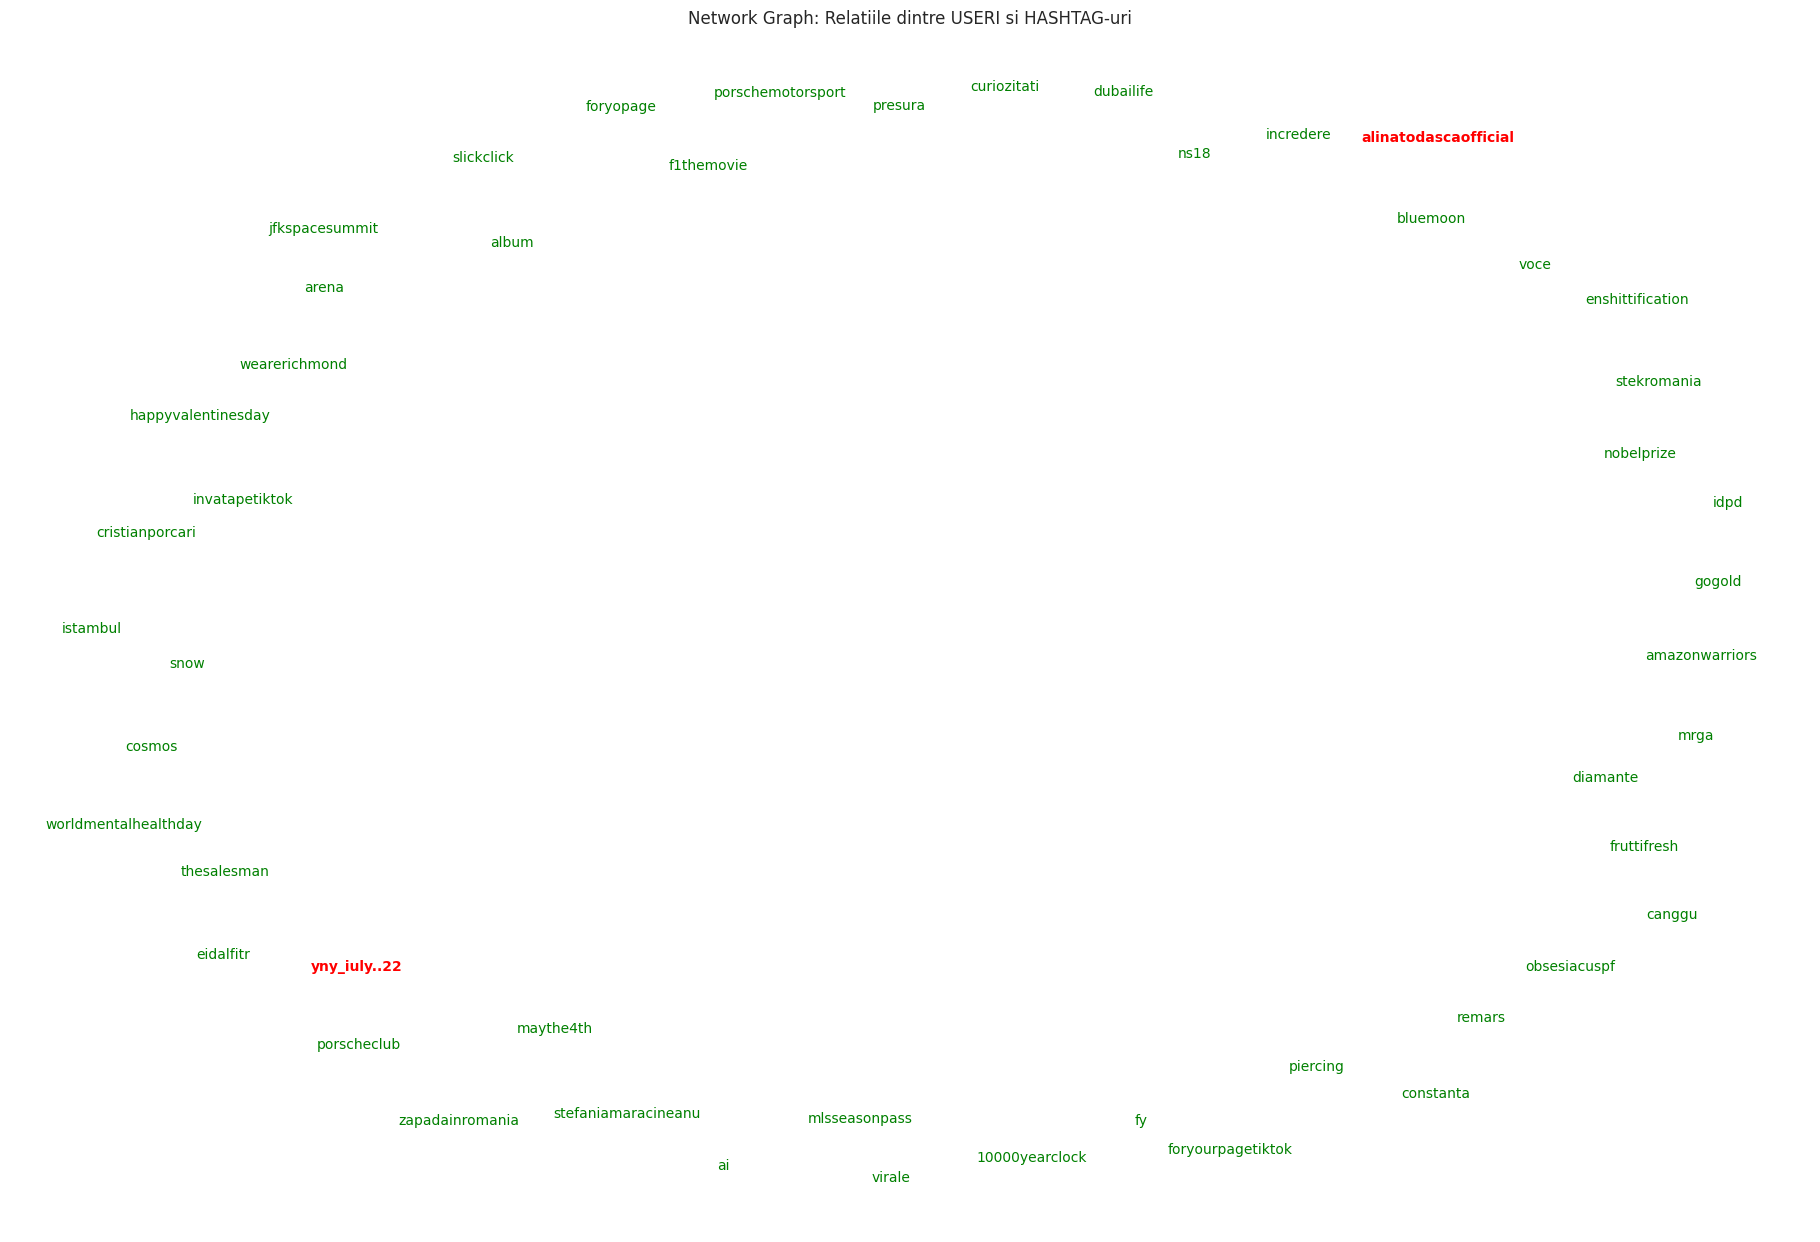

In [99]:
import matplotlib.pyplot as plt

F = G.subgraph(user_nodes + hashtag_nodes)

degree_centrality_F = nx.degree_centrality(F)

top_nodes_F = sorted(degree_centrality_F, key=degree_centrality_F.get, reverse=True)[:50]

nodes_to_draw = set(top_nodes_F)
for node in top_nodes_F:
    nodes_to_draw.update(F.neighbors(node))

H_viz = F.subgraph(nodes_to_draw)

node_sizes_F = []

for node in H_viz.nodes():
    attr = F.nodes[node]

    if attr.get('node_type') == 'USER':
        node_sizes_F.append(degree_centrality_F[node] * 5000)

    elif attr.get('node_type') == 'HASHTAG':
        node_sizes_F.append(degree_centrality_F[node] * 3000)


# Desenarea grafului
plt.figure(figsize=(18, 12))
plt.clf()
pos = nx.spring_layout(H_viz, k=0.5, iterations=50)

# Desenarea modurilor si muchiilor
nx.draw(H_viz,
        pos,
        node_color='gray',
        node_size=node_sizes_F,
        edge_color='lightgray',
        with_labels=False,
        linewidths=1,
        alpha=0.8)

# Desenarea etichetelor (USER vs. HASHTAG)

user_labels = {n: n for n, attr in H_viz.nodes(data=True) if attr.get('node_type') == 'USER'}
hashtag_labels = {n: n for n, attr in H_viz.nodes(data=True) if attr.get('node_type') == 'HASHTAG'}


nx.draw_networkx_labels(
    H_viz,
    pos,
    labels=user_labels,
    font_size=10,
    font_color='red',
    font_weight='extra bold'
)

nx.draw_networkx_labels(
    H_viz,
    pos,
    labels=hashtag_labels,
    font_size=10,
    font_color='green',
    font_weight='normal'
)


plt.title("Network Graph: Relatiile dintre USERI si HASHTAG-uri")
plt.savefig("network_graph_final.png", facecolor='white', transparent=False, dpi=300)
plt.show()

/tmp/ipython-input-670300178.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Platforma')


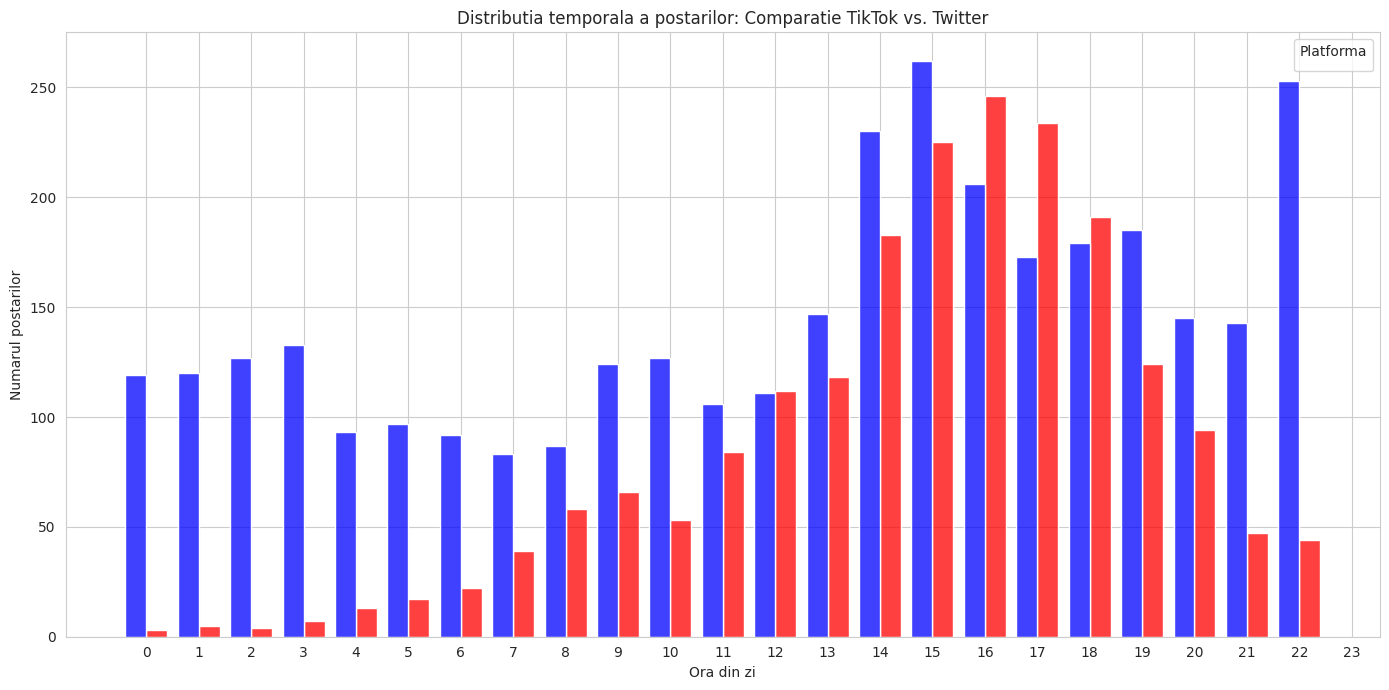

In [95]:
import seaborn as sns
import numpy as np

final_data['post_time_of_day'] = final_data['post_time_of_day'].astype(int)

sns.set_style("whitegrid")

# Plot 1: Comparatie Platforma vs. Ora
plt.figure(figsize=(14, 7))

sns.histplot(
    data=final_data,
    x='post_time_of_day',
    hue='platform',
    multiple='dodge',
    bins=24,
    binwidth=1,
    palette={'TikTok': 'red', 'Twitter': 'blue'},
    shrink=0.8
)

plt.title("Distributia temporala a postarilor: Comparatie TikTok vs. Twitter")
plt.xlabel("Ora din zi")
plt.ylabel("Numarul postarilor")
plt.xticks(ticks=np.arange(0.5, 24.5, 1), labels=range(24))
plt.legend(title='Platforma')
plt.tight_layout()
plt.savefig("histograma_comparativa_temporala.png")
plt.show()



/tmp/ipython-input-3540494429.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Sentiment')


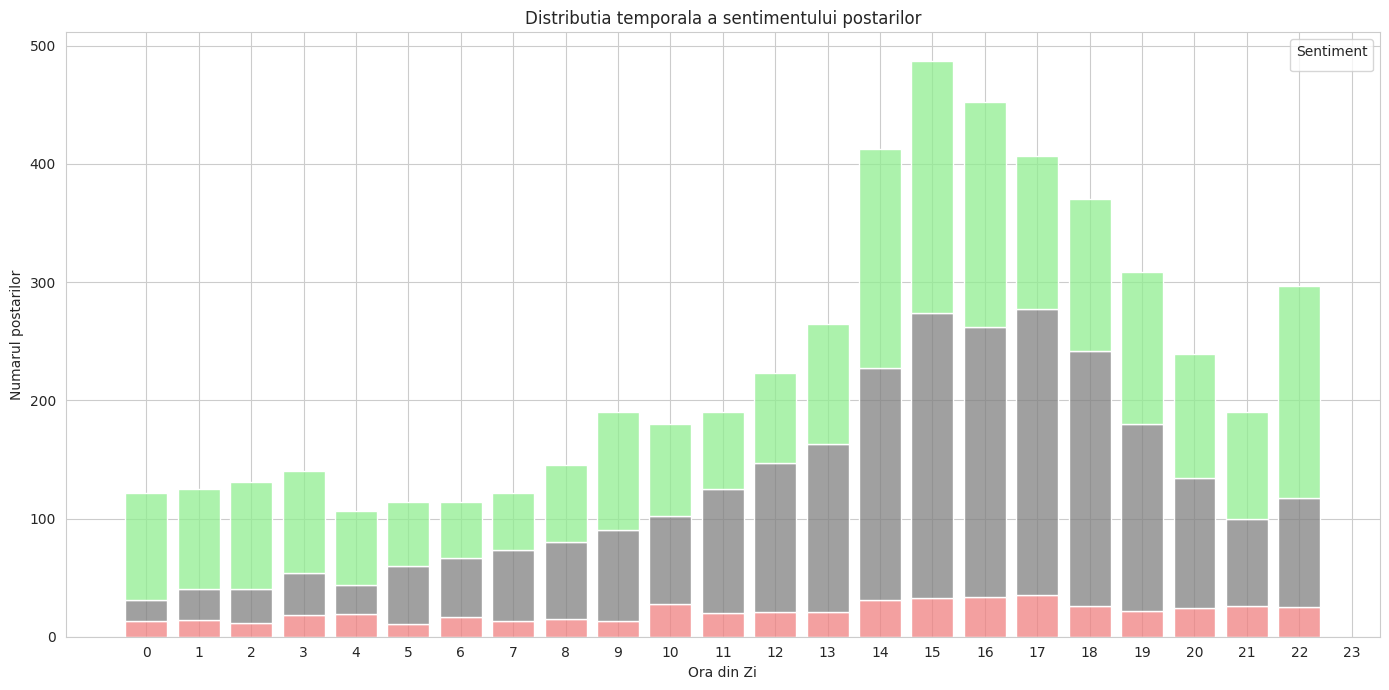

In [96]:
# Plot 2: Distributia sentimentului in timp
if 'sentiment_category' in final_data.columns:
    plt.figure(figsize=(14, 7))

    sns.histplot(
        data=final_data,
        x='post_time_of_day',
        hue='sentiment_category',
        multiple='stack',
        bins=24,
        binwidth=1,
        palette={'Positive': 'lightgreen', 'Neutral': 'gray', 'Negative': 'lightcoral'},
        shrink=0.8
    )
    plt.title("Distributia temporala a sentimentului postarilor")
    plt.xlabel("Ora din Zi")
    plt.ylabel("Numarul postarilor")
    plt.xticks(ticks=np.arange(0.5, 24.5, 1), labels=range(24))
    plt.legend(title='Sentiment')
    plt.tight_layout()
    plt.savefig("histograma_sentiment_temporala.png")
    plt.show()

3.

In [73]:
!pip install elasticsearch

In [97]:

from elasticsearch import Elasticsearch
from elasticsearch.helpers import bulk
import time

ES_ENDPOINT = "https://my-elasticsearch-project-af6910.es.europe-west1.gcp.elastic.cloud:443"

ES_API_KEY = "ZU5EYnU1b0JhakxDeWV2TkZqaHo6ajk2aWlxdnVhVkVrSTVkMmY2blJsZw=="

ES_INDEX = "osint_social_media_analysis"

# Procesul de ingestie
try:
    # Conectarea la Elasticsearch
    es = Elasticsearch(
        hosts=ES_ENDPOINT,
        api_key=ES_API_KEY
    )

    if not es.ping():
        raise ValueError("Conexiunea la Elasticsearch a esuat.")

    print(f"Conexiune la Elasticsearch este reusita. Cluster: {es.info().body['cluster_name']}")

    if es.indices.exists(index=ES_INDEX):
        es.indices.delete(index=ES_INDEX)
        print(f"Indexul vechi '{ES_INDEX}' a fost șters.")

    es.indices.create(index=ES_INDEX)
    print(f"Indexul nou '{ES_INDEX}' a fost creat.")

    # Pregătirea Datelor
    def generate_actions(df):

        df_clean = df.where(pd.notnull(df), None)

        for index, row in df_clean.iterrows():
            doc = row.to_dict()

            yield {
                "_index": ES_INDEX,
                "_id": doc['post_id'],
                "_source": doc
            }

    print("Inceperea ingestiei datelor ")
    start_time = time.time()
    success, errors = bulk(es, generate_actions(final_data))
    end_time = time.time()

    print(f"\nIngestie finalizata:")
    print(f"  Succes: {success} documente")
    if errors:
        print(f"  Erori: {len(errors)}")
    print(f"  Timp total: {end_time - start_time:.2f} secunde")

    es.indices.refresh(index=ES_INDEX)

except Exception as e:
    print(f"Eroare in timpul procesului de ingestie: {e}")

Conexiune la Elasticsearch este reusita. Cluster: af69106bfef743ea950ab3225e1ce55d
Indexul vechi 'osint_social_media_analysis' a fost șters.
Indexul nou 'osint_social_media_analysis' a fost creat.
Inceperea ingestiei datelor 

Ingestie finalizata:
  Succes: 5331 documente
  Timp total: 22.67 secunde
